===== 并行执行计划 =====
Layer 0:
  CPU: prim::Constant_0 (prim::Constant)
Layer 1:
  CPU: prim::Constant_1 (prim::Constant)
Layer 2:
  CPU: prim::Constant_2 (prim::Constant)
Layer 3:
  CPU: prim::Constant_3 (prim::Constant)
Layer 4:
  CPU: prim::Constant_4 (prim::Constant)
Layer 5:
  CPU: prim::Constant_5 (prim::Constant)
Layer 6:
  CPU: prim::Constant_6 (prim::Constant)
Layer 7:
  CPU: prim::Constant_7 (prim::Constant)
Layer 8:
  CPU: prim::Constant_8 (prim::Constant)
Layer 9:
  CPU: prim::ListConstruct_14 (prim::ListConstruct)
输出形状: torch.Size([32, 50, 128])
计算图切分可视化已保存为 graph_partition.png


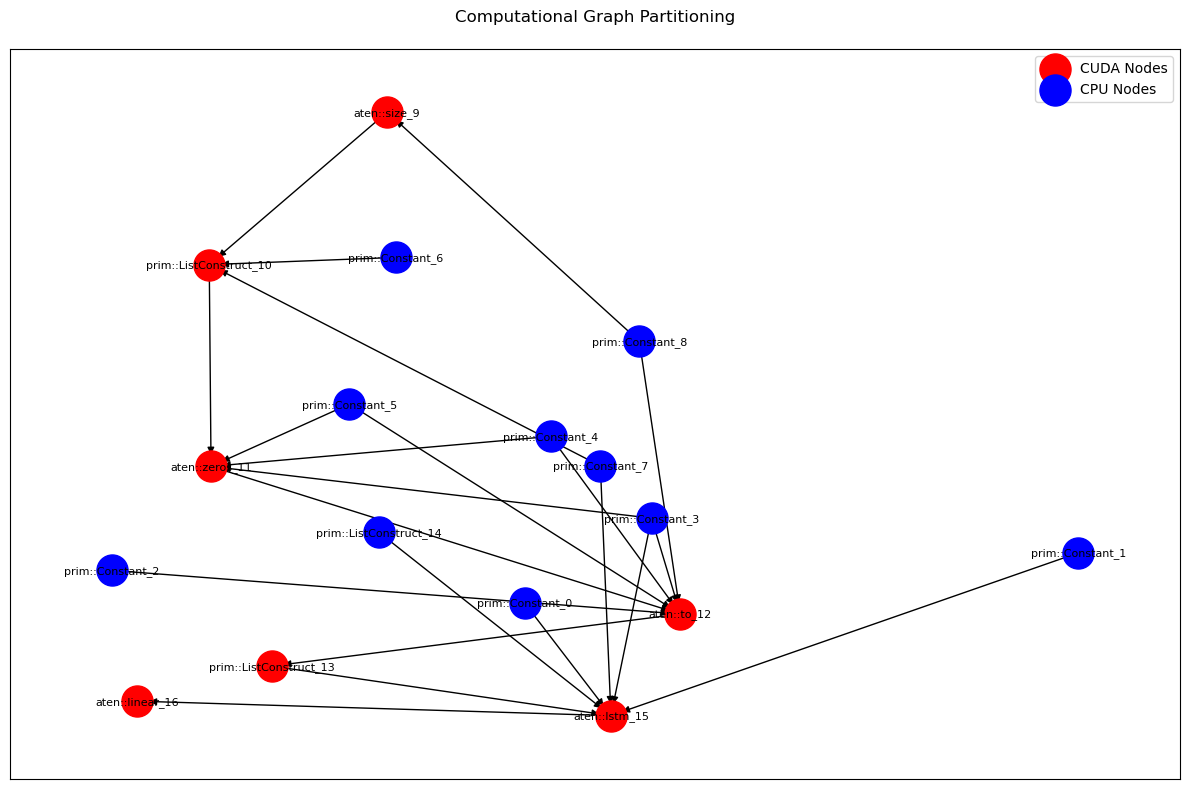

In [2]:
import torch
import torch.nn as nn
import networkx as nx
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
import matplotlib.pyplot as plt

class Config:
    """模型参数配置类"""
    seq_length = 50      # 输入序列长度
    input_size = 128     # 输入特征维度
    hidden_size = 512    # LSTM隐藏层大小
    num_layers = 2       # LSTM层数
    batch_size = 32      # 批处理大小

class HeteroLSTM(nn.Module):
    """异构LSTM模型(CPU+GPU混合)"""
    def __init__(self):
        super().__init__()
        # LSTM层默认在CPU（适合序列处理）
        self.lstm = nn.LSTM(
            input_size=Config.input_size,
            hidden_size=Config.hidden_size,
            num_layers=Config.num_layers,
            batch_first=True
        )
        # 全连接层默认在GPU（适合并行计算）
        self.fc = nn.Linear(Config.hidden_size, Config.input_size)

    def forward(self, x):
        """前向传播（自动匹配输入设备）"""
        # 初始化隐藏状态（自动匹配输入设备）
        h0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to(x.device)
        c0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to(x.device)
        
        # LSTM处理
        out, _ = self.lstm(x, (h0, c0))
        
        # 全连接层处理（自动匹配设备）
        return self.fc(out)

class EnhancedDynamicSplitter:
    """基于动态规划的增强型计算图切分器"""
    def __init__(self):
        # 设备硬件规格（需根据实际设备校准）
        self.device_config = {
            "cpu": {"flops": 1e9, "mem_bw": 50e9},   # CPU配置（算力，内存带宽）
            "cuda": {"flops": 10e12, "mem_bw": 900e9}  # GPU配置（算力，内存带宽）
        }
        
        # 算子到设备的默认映射规则
        self.op_mapping = {
            "lstm": "cpu",      # LSTM更适合CPU顺序处理
            "linear": "cuda"    # 矩阵乘法更适合GPU并行
        }
        
        # 并发控制资源
        self.cpu_pool = ThreadPoolExecutor(max_workers=4)  # CPU线程池
        self.gpu_stream = torch.cuda.Stream()  # GPU流

    def build_graph(self, model, example_input):
        """构建计算图DAG"""
        with torch.no_grad():
            traced = torch.jit.trace(model, example_input)
            graph = traced.graph_for(example_input)
            
        G = nx.DiGraph()  # 创建有向无环图
        node_mapping = {}  # 节点名称映射表
        
        # 第一遍：添加所有计算节点
        for node in graph.nodes():
            if node.kind() == 'prim::GetAttr':
                continue  # 跳过属性节点
                
            # 生成唯一节点名
            node_name = f"{node.kind()}_{len(node_mapping)}"
            node_mapping[node] = node_name
            
            # 根据算子类型分配默认设备（初始化设备）
            device = 'cuda'  # 默认设备
            for op_type, dev in self.op_mapping.items():
                if op_type in node.kind().lower():
                    device = dev
                    break
                    
            # 添加节点属性
            G.add_node(node_name,
                      op_type=node.kind(),
                      device=device,
                      output_size=self._estimate_output_size(node))
        
        # 第二遍：添加数据依赖边
        for node in graph.nodes():
            if node not in node_mapping:
                continue
                
            # 遍历当前节点的所有输入
            for inp in node.inputs():
                # 检查输入是否来自已注册的节点
                if inp.node() in node_mapping:
                    # 添加边：从输入节点->当前节点
                    G.add_edge(node_mapping[inp.node()], node_mapping[node])
                    
        return G

    def _estimate_output_size(self, node):
        """估算节点输出张量大小（字节数）"""
        if 'lstm' in node.kind().lower():
            return Config.batch_size * Config.seq_length * Config.hidden_size * 4  # float32=4字节
        elif 'linear' in node.kind().lower():
            return Config.batch_size * Config.seq_length * Config.input_size * 4
        return 1  # 默认值（应避免）

    def split_graph(self, G):
        """
        改进的动态规划切分算法
        返回：{设备: [节点列表], ...} 和 并行执行计划
        """
        devices = list(self.device_config.keys())
        dp_table = {n: {d: float('inf') for d in devices} for n in G.nodes()}
        path = {}

        # 初始化无前驱节点
        for node in G.nodes():
            if not list(G.predecessors(node)):
                for d in devices:
                    dp_table[node][d] = self._compute_node_cost(node, G, d)

        # 动态规划填充表格
        for node in nx.topological_sort(G):
            preds = list(G.predecessors(node))
            if not preds:
                continue

            for curr_dev in devices:
                compute_cost = self._compute_node_cost(node, G, curr_dev)
                max_pred_cost = 0  # 用于记录前驱中的最大成本
                best_pred_devs = {}

                # 计算每个前驱的最优路径
                for pred in preds:
                    # 找到前驱的最佳设备（成本最低）
                    best_dev = min(devices, key=lambda d: dp_table[pred][d])
                    
                    # 计算通信成本
                    comm_cost = self._compute_comm_cost(pred, best_dev, curr_dev, G)
                    
                    # 记录最大前驱成本
                    max_pred_cost = max(max_pred_cost, dp_table[pred][best_dev] + comm_cost)
                    best_pred_devs[pred] = best_dev

                total_cost = compute_cost + max_pred_cost  # 总成本=当前计算+最大前驱成本
                if total_cost < dp_table[node][curr_dev]:
                    dp_table[node][curr_dev] = total_cost
                    path[node] = {curr_dev: best_pred_devs}

        # 回溯获取最优路径
        best_partitions = defaultdict(list)
        if not G.nodes():
            return dict(best_partitions), []

        last_node = list(nx.topological_sort(G))[-1]
        curr_dev = min(dp_table[last_node].items(), key=lambda x: x[1])[0]
        stack = [(last_node, curr_dev)]
        visited = set()

        while stack:
            node, dev = stack.pop()
            if (node, dev) in visited:
                continue
            visited.add((node, dev))
            best_partitions[dev].append(node)
            
            if node in path and dev in path[node]:
                for pred, pred_dev in path[node][dev].items():
                    stack.append((pred, pred_dev))

        # 第二步：生成并行执行计划
        parallel_plan = self._generate_parallel_plan(G, best_partitions)
        
        return dict(best_partitions), parallel_plan

    def _generate_parallel_plan(self, G, partitions):
        """
        生成并行执行计划
        返回：[[可并行节点组1], [可并行节点组2], ...]
        """
        # 按设备生成子图拓扑排序
        device_toposort = {}
        for device, nodes in partitions.items():
            subgraph = G.subgraph(nodes)
            device_toposort[device] = list(nx.topological_sort(subgraph))
        
        # 合并生成全局并行层
        parallel_layers = []
        depths = [len(seq) for seq in device_toposort.values()]
        max_depth = max(depths) if depths else 0

        for i in range(max_depth):
            current_layer = []
            for device in device_toposort:
                if i < len(device_toposort[device]):
                    node = device_toposort[device][i]
                    # 检查是否所有前驱都已处理
                    preds = list(G.predecessors(node))
                    if all(any(pred in layer for layer in parallel_layers) for pred in preds):
                        current_layer.append((device, node))
            if current_layer:
                parallel_layers.append(current_layer)
                
        return parallel_layers

    def _compute_node_cost(self, node, G, target_dev):
        """计算节点在目标设备上的纯计算时间"""
        try:
            # 计算输入数据总量
            input_size = sum(G.nodes[p]['output_size'] for p in G.predecessors(node))
            
            # 获取设备算力
            flops = self.device_config[target_dev]["flops"]
            
            # 计算纯计算时间（假设每个字节需要2次浮点运算）
            compute_time = (input_size * 2) / flops
            
            # 计算跨设备通信时间
            comm_time = 0
            for p in G.predecessors(node):
                if G.nodes[p]['device'] != target_dev:
                    # 使用两端设备的最小带宽
                    bw = min(
                        self.device_config[target_dev]["mem_bw"],
                        self.device_config[G.nodes[p]['device']]["mem_bw"]
                    )
                    # 通信时间 = 数据量 / 带宽
                    comm_time += G.nodes[p]['output_size'] / bw
                    
            # 总成本 = 计算时间 + 通信时间的0.5倍（经验系数）
            return compute_time + comm_time * 0.5
        except Exception as e:
            print(f"Error calculating cost for {node}: {str(e)}")
            return float('inf')

    def _compute_comm_cost(self, src_node, src_dev, dst_dev, G):
        """改进的通信成本计算"""
        # 获取数据大小
        data_size = G.nodes[src_node]['output_size']
        
        # 使用两端设备的最小带宽
        bw = min(
            self.device_config[src_dev]["mem_bw"],
            self.device_config[dst_dev]["mem_bw"]
        )
        
        # 固定开销（实测建议值）
        fixed_overhead = 10e-6  # 10 microseconds
        
        # 总通信时间 = 固定开销 + 数据传输时间
        return fixed_overhead + data_size / bw

class ParallelExecutor:
    """并发执行器"""
    def __init__(self, model):
        self.model = model
        self.splitter = EnhancedDynamicSplitter()
        self.partitions = None
        self.parallel_plan = None
        self.G = None  # 存储计算图

    def prepare(self, example_input):
        """预编译计算图"""
        # 构建计算图
        self.G = self.splitter.build_graph(self.model, example_input)
        
        # 切分计算图
        self.partitions, self.parallel_plan = self.splitter.split_graph(self.G)
        
        # 打印执行计划
        self._print_plan()

    def _print_plan(self):
        """打印并行执行计划"""
        print("===== 并行执行计划 =====")
        for i, layer in enumerate(self.parallel_plan):
            print(f"Layer {i}:")
            for device, node in layer:
                print(f"  {device.upper()}: {node} ({self.G.nodes[node]['op_type']})")

    def execute(self, x):
        """执行并行计算"""
        # 初始化中间结果存储
        node_outputs = {}
        
        # 按并行层执行
        for layer in self.parallel_plan:
            futures = {}  # 存储异步任务
            
            # 提交当前层所有任务
            for device, node in layer:
                if device == 'cpu':
                    # 提交到CPU线程池
                    futures[node] = self.splitter.cpu_pool.submit(
                        self._run_cpu_op, node, x, node_outputs.copy()
                    )
                else:
                    # 提交到GPU流
                    with torch.cuda.stream(self.splitter.gpu_stream):
                        node_outputs[node] = self._run_gpu_op(node, x, node_outputs)
            
            # 等待当前层CPU任务完成
            for node, future in futures.items():
                node_outputs[node] = future.result()
                
        # 同步GPU流
        if self.splitter.gpu_stream:
            self.splitter.gpu_stream.synchronize()
            
        # 返回最终结果
        last_node = self.parallel_plan[-1][-1][1]
        return node_outputs[last_node]

    def _run_cpu_op(self, node_name, x, node_outputs):
        """执行CPU算子"""
        # 实际工程需要根据节点类型调用具体操作
        if 'lstm' in node_name:
            h0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to('cpu')
            c0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to('cpu')
            out, _ = self.model.lstm(x.to('cpu'), (h0, c0))
            return out
        return x  # 默认返回输入

    def _run_gpu_op(self, node_name, x, node_outputs):
        """执行GPU算子"""
        if 'linear' in node_name:
            # 获取前驱节点的输出
            inputs = []
            for pred in node_outputs:
                if pred in node_outputs:
                    inputs.append(node_outputs[pred])
            if inputs:
                return self.model.fc(inputs[0].to('cuda'))
        return x.to('cuda')  # 默认返回输入

def visualize_partition(splitter, G, partitions):
    """可视化计算图切分"""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5)  # k控制节点间距
    
    colors = {
        'cpu': 'blue',
        'cuda': 'red'
    }
    
    for device, nodes in partitions.items():
        nx.draw_networkx_nodes(
            G, pos, nodelist=nodes,
            node_color=colors[device],
            node_size=500,
            label=f'{device.upper()} Nodes'
        )
        
    nx.draw_networkx_edges(G, pos, arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.legend(scatterpoints=1)
    plt.title("Computational Graph Partitioning", pad=20)
    plt.tight_layout()
    plt.savefig("graph_partition.png", dpi=300)
    print("计算图切分可视化已保存为 graph_partition.png")

if __name__ == "__main__":
    # 模型初始化
    model = HeteroLSTM().eval()
    executor = ParallelExecutor(model)
    
    # 准备输入数据
    input_data = torch.randn(Config.batch_size, Config.seq_length, Config.input_size)
    
    # 预编译计算图
    executor.prepare(input_data)
    
    # 执行并行计算
    output = executor.execute(input_data)
    print(f"输出形状: {output.shape}")
    
    # 可视化
    visualize_partition(executor.splitter, executor.G, executor.partitions)